<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [26]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import cv2

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.4.1
Eager mode: True
Found GPU at: /device:GPU:0


In [3]:
def show_prediction(image, label, prediction):
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(image.reshape(28, 28), cmap='Greys')
  plt.title("Prediction: %s / Truth: %s" % (np.argmax(prediction), label))
  plt.show()

In [4]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    height_zoom = size[1] / cam.shape[0]
    width_zoom = size[0] / cam.shape[1]
    heatmap = sp.ndimage.zoom(cam, (height_zoom, width_zoom), order=2)
 
  return heatmap

In [5]:
def show_heatmap(img, cam, size, resize=True, title=None):
  img = img.reshape(size[0], size[1])
  heatmap = get_heatmap(cam, size, resize)

  # plot
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(img, alpha=0.5, cmap='Greys')
  plt.imshow(heatmap, cmap='jet', alpha=0.5)
  
  if title is not None:
    plt.title(title)
  
  plt.show()  

In [6]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [7]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [8]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [9]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [10]:
def get_prediction(model, test, idx=-1):
  if idx < 0:
    idx = random.randint(0, len(test[0]))

  image = test[0][idx]
  label = np.argmax(test[1][idx])
  prediction = model.predict(np.expand_dims(image, 0))

  return image, label, prediction, idx

In [11]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

#MNIST

In [12]:
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(10, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


Epoch 1/15
422/422 [==============================] - 36s 7ms/step - loss: 0.9410 - accuracy: 0.7070 - val_loss: 0.1239 - val_accuracy: 0.9638
Epoch 2/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1882 - accuracy: 0.9423 - val_loss: 0.0902 - val_accuracy: 0.9742
Epoch 3/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1336 - accuracy: 0.9586 - val_loss: 0.0662 - val_accuracy: 0.9808
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1035 - accuracy: 0.9679 - val_loss: 0.0605 - val_accuracy: 0.9828
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0926 - accuracy: 0.9708 - val_loss: 0.0533 - val_accuracy: 0.9828
Epoch 6/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0748 - accuracy: 0.9765 - val_loss: 0.0502 - val_accuracy: 0.9847
Epoch 7/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0734 - accuracy: 0.9762 - val_loss: 0.0399 - val_accuracy: 0.9892
Epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


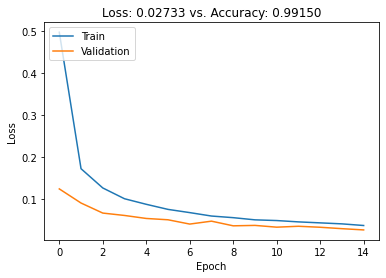

In [13]:
model_mnist = create_mnist_model("gap_shallow", (28, 28, 1), 10, mnist_train)

# model_mnist, history_mnist = load_model("gap_shallow")
start_time = time.clock()
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

model_mnist.summary()
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)

plot_model_score(score_mnist, history_mnist.history)

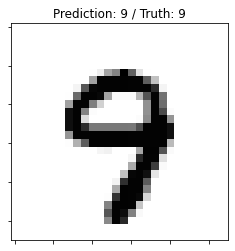

In [14]:
image, label, prediction, _ = get_prediction(model_mnist, mnist_test)
show_prediction(image, label, prediction)

#GEO

In [31]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", 3)
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset_dataset.npz", 6)
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", 6)
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", 18)

def get_geo_dataset(name, filepath):
  path = tf.keras.utils.get_file(name, filepath)
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [30]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
       
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.3),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

18841600/18841002 [==============================] - 1s 0us/step
(28, 28)
1
x_train shape: (4200, 28, 28, 1)
4200 train samples
1800 test samples
Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


30/30 [==============================] - 2s 37ms/step - loss: 1.7617 - accuracy: 0.1688 - val_loss: 1.6372 - val_accuracy: 0.2405
Epoch 2/15
30/30 [==============================] - 1s 21ms/step - loss: 1.5038 - accuracy: 0.4539 - val_loss: 0.9704 - val_accuracy: 0.7738
Epoch 3/15
30/30 [==============================] - 1s 21ms/step - loss: 0.8972 - accuracy: 0.7175 - val_loss: 0.6332 - val_accuracy: 0.8500
Epoch 4/15
30/30 [==============================] - 1s 20ms/step - loss: 0.6280 - accuracy: 0.8228 - val_loss: 0.4894 - val_accuracy: 0.8548
Epoch 5/15
30/30 [==============================] - 1s 21ms/step - loss: 0.5170 - accuracy: 0.8310 - val_loss: 0.4005 - val_accuracy: 0.9190
Epoch 6/15
30/30 [==============================] - 1s 21ms/step - loss: 0.4408 - accuracy: 0.8655 - val_loss: 0.3447 - val_accuracy: 0.9071
Epoch 7/15
30/30 [==============================] - 1s 21ms/step - loss: 0.3724 - accuracy: 0.8947 - val_loss: 0.2852 - val_accuracy: 0.9381
Epoch 8/15
30/30 [======

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


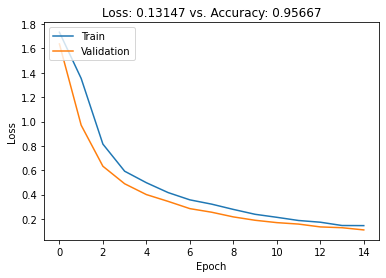

In [32]:
dataset = geo_dataset_simple
geo_train, geo_test = get_geo_dataset(dataset[0], dataset[1])
geo_train, geo_test = format_dataset(dataset[2], geo_train, geo_test)
model_geo = create_geo_model("geocam", (28, 28, 1), dataset[2])
# model_geo, history_geo = load_model("geo")

start_time = time.clock()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.1)
print("Training took: %.2f seconds" % (time.clock() - start_time))
# save_model(model_geo, history_geo, "geo")

model_geo.summary()
score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)

plot_model_score(score_geo, history_geo.history)

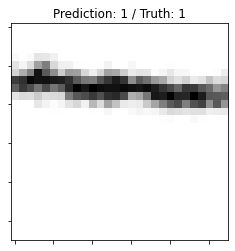

In [33]:
image, label, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, label, prediction)

#Prototype


## GCM

In [ ]:
geo_layers = get_cam_layers(keras.models.clone_model(model_geo))
mnist_layers = get_cam_layers(keras.models.clone_model(model_mnist))

model_gcm = keras.Sequential()

for layer in geo_layers[0]:
  layer.trainable = False
  model_gcm.add(layer)

model_gcm.add(layers.Dropout(0.3))
model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.GlobalAveragePooling2D())
model_gcm.add(layers.Dense(10, activation="softmax"))

# for layer in mnist_layers[1]:
  # model_gcm.add(layer)

opt = keras.optimizers.Adam(learning_rate=0.002)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

start_time = time.clock()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=20, validation_split=0.2)
print("Training took: %.2f seconds" % (time.clock() - start_time))

score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
model_gcm.summary()
plot_model_score(score_gcm, history_geocam.history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 1/20
375/375 [==============================] - 39s 102ms/step - loss: 2.0118 - accuracy: 0.2323 - val_loss: 1.6903 - val_accuracy: 0.3735
Epoch 2/20
375/375 [==============================] - 38s 100ms/step - loss: 1.0782 - accuracy: 0.6339 - val_loss: 1.1232 - val_accuracy: 0.6208
Epoch 3/20
375/375 [==============================] - 38s 101ms/step - loss: 0.6902 - accuracy: 0.7789 - val_loss: 0.7830 - val_accuracy: 0.7197
Epoch 4/20
375/375 [==============================] - 38s 100ms/step - loss: 0.5211 - accuracy: 0.8380 - val_loss: 0.7442 - val_accuracy: 0.7258
Epoch 5/20
375/375 [==============================] - 38s 100ms/step - loss: 0.4390 - accuracy: 0.8645 - val_loss: 0.5109 - val_accuracy: 0.8277
Epoch 6/20
375/375 [==============================] - 38s 100ms/step - loss: 0.3928 - accuracy: 0.8796 - val_loss: 0.4613 - val_accuracy: 0.8432
Epoch 7/20
375/375 [==============================] - 38s 100ms/step - loss: 0.3445 - accuracy: 0.8933 - val_loss: 0.4122 - val_ac

##GEO-CAM

In [20]:
# geo_layers = get_cam_layers(keras.models.clone_model(model_geo))
gcm_layers = get_cam_layers(keras.models.clone_model(model_gcm))

model_gcg = keras.Sequential()

for layer in geo_layers[1]:
  layer.trainable = False
  model_gcg.add(layer)

# model_gcg = Model([gcm_gap_layer.input], [gcm_gap_layer.output, model_gcm.output])

In [21]:
def grad_cam_pp(image, model, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  heatmap_model = Model([model.inputs], [cam_layers[0][-1].get_output_at(0), model.output])

  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = heatmap_model(np.expand_dims(image, 0))
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, (conv_first_grad, conv_second_grad, conv_third_grad)

In [22]:
def cam_1(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[1][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

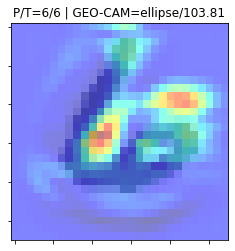

In [23]:
# 1 - 3455
# 4 - 6195
# 0 - 3710
# 6 - 6187
# 7 - 6606
# 5 - 6148
# 9 - 5622
test_img_idx = 6187

# GCM
gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_img_idx)
gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_grads = grad_cam_pp(gcm_mnist_image, model_gcm, gcm_prediction_idx)

# GCG
gcg_prediction_idx = 2#np.argmax(model_gcg(gcm_conv_output))
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, gcg_prediction_idx)
gcg_mnist_cam_max = np.max(gcg_mnist_cam)

geo_labels = ["vertical", "diagonal", "ellipse"]
title = "P/T=%i/%i | GEO-CAM=%s/%.2f" % (gcm_prediction_idx, np.argmax(mnist_test[1][test_img_idx]), geo_labels[gcg_prediction_idx], gcg_mnist_cam_max)
show_heatmap(gcm_mnist_image, gcg_mnist_cam, (28, 28, 1), True, title)